In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/tmp/ipykernel_208093/3202773982.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Catalogues of clusters and photon lists:

In [2]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [41]:
clusters_31 = clusters[clusters["M500"]>1.54e+14]#.index
len(clusters_31)

31

In [4]:
#max(clusters["M500"])
#sorted_df = clusters.sort_values(by='M500', ascending=True)
#pp = sorted_df[-10:] #.index.to_numpy()
#pp

#### Stacked image of all slices in the lightcone:

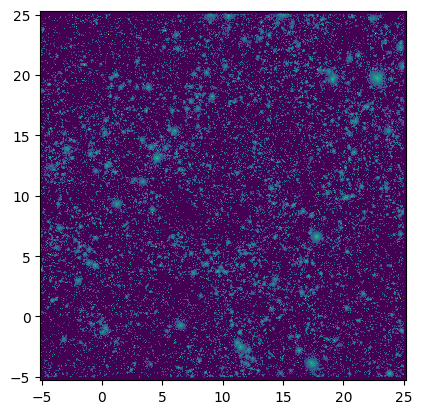

In [4]:
t_all = pd.DataFrame([])
for p in phlists:
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/"+p, hdu=2)
    t_all = vstack([t_all, t])
    
plt.hist2d(t_all["RA"], t_all["DEC"], bins=2000, norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

### Binning clusters:

In [5]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


In [6]:
zxs = np.array([clusters.loc[i]["z_true"] for i in clusters.index])

masses = np.array([clusters.loc[i]["M500"]/10**14 for i in clusters.index])

### Catalogue of galaxies:

In [6]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


# Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


1.2316289955824629
1.2316289955824629


<Figure size 640x480 with 0 Axes>

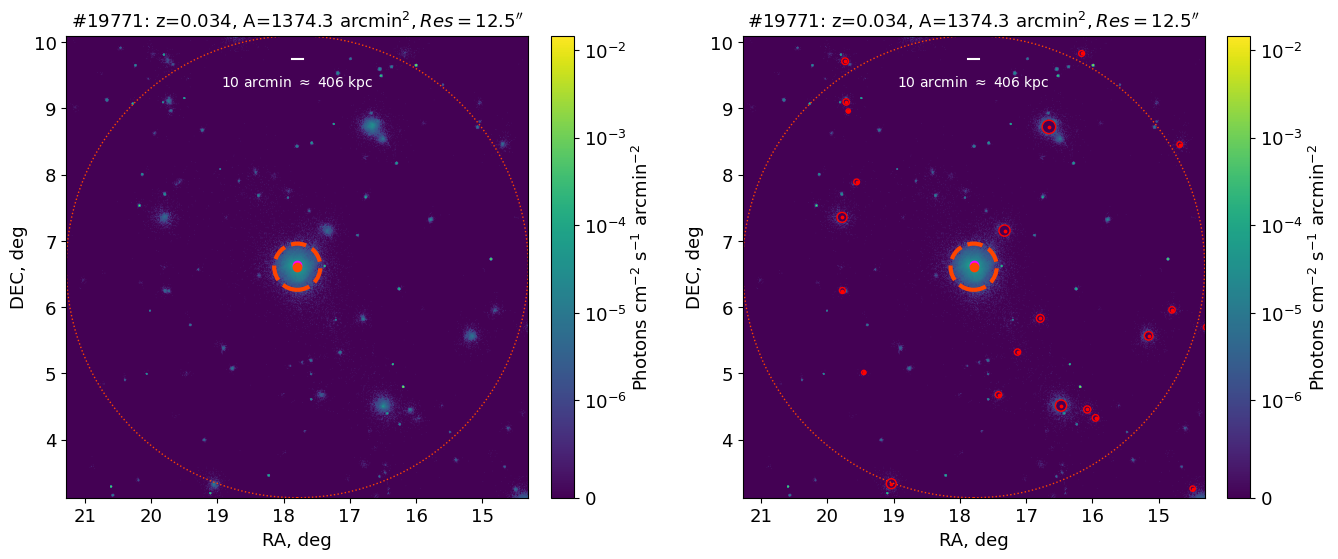

In [55]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(16,6))
plt.tight_layout()

cl_num = 19771

display(clusters[clusters.index==cl_num])

plt.subplot(121)
pho_hist1 = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

plt.subplot(122)
pho_hist2, msk = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=True, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

#print(sum(pho_hist1.flatten()), sum(pho_hist2.flatten()))
#display(plist1, plist2)

plt.show()

This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 2000 pixels in length) to obtain the flux in corresponding units.

## Drawing panels

In [ ]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('panels.png', format='png', dpi=100, bbox_inches='tight')
plt.close()
plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

# Calculating brightness profile for one cluster:

Original:

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


<Figure size 640x480 with 0 Axes>

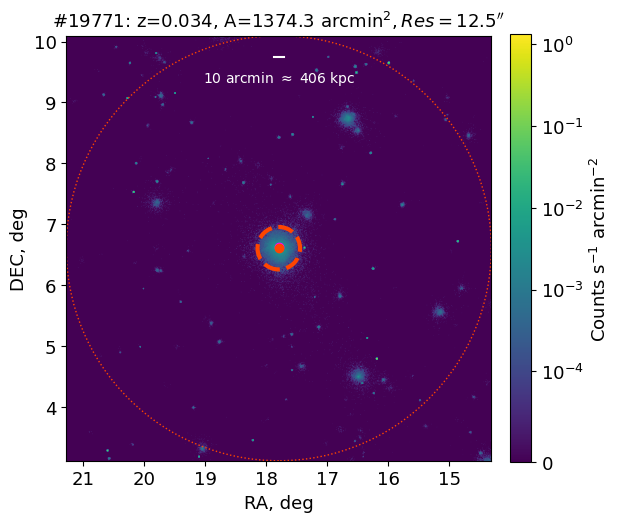

In [53]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6,6))

cl_num = 19771

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001, 
                                     ARF_weights=True)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

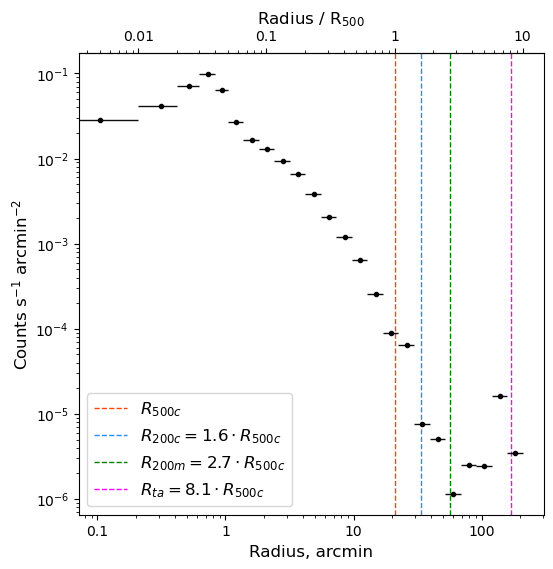

(array([1.04428739e-01, 3.13286216e-01, 5.22143693e-01, 7.31001170e-01,
       9.39858647e-01, 1.21221962e+00, 1.60209458e+00, 2.11736141e+00,
       2.79834873e+00, 3.69835569e+00, 4.88782354e+00, 6.45984891e+00,
       8.53747023e+00, 1.12832976e+01, 1.49122401e+01, 1.97083256e+01,
       2.60469316e+01, 3.44241648e+01, 4.54956898e+01, 6.01280467e+01,
       7.94664729e+01, 1.05024538e+02, 1.38802606e+02, 1.83444402e+02]), array([2.87140195e-02, 4.18165889e-02, 7.05514222e-02, 9.90447648e-02,
       6.39339839e-02, 2.65658710e-02, 1.66182634e-02, 1.28192284e-02,
       9.32728774e-03, 6.61274700e-03, 3.78683642e-03, 2.08077398e-03,
       1.21207238e-03, 6.46324284e-04, 2.59536520e-04, 8.81272163e-05,
       6.39493267e-05, 7.63236977e-06, 5.05644185e-06, 1.15460314e-06,
       2.51149716e-06, 2.46698338e-06, 1.63962184e-05, 3.48022543e-06]), 2.088574771861023, 5.124510578086629e+43)


In [56]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

profile = brightness_profile(clusternumber=cl_num,
                             hist=tyty0,
                             mmmask='no',
                             field_length=20,
                             draw=True,
                             ARF_weights=True,
                             errors=False)

plt.show()

print(profile)

## OBSOLETE

In [111]:
r_pixels_max = 1000

setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
print(setka_bins)
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
print(setka)
err = np.diff(setka_bins)/2
print(err)
print(setka+err)

[   0.            1.            2.            3.            4.
    5.            6.60810365    8.73340676   11.54225142   15.25447874
   20.16063531   26.64471355   35.21420576   46.5398243    61.50799654
   81.29024325  107.43487058  141.98815202  187.65448504  248.0080574
  327.77258973  433.19104912  572.51427033  756.64672756 1000.        ]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.804051823584011, 7.670755204755542, 10.137829089015636, 13.39836507549806, 17.70755702429748, 23.402674430939175, 30.929459652114993, 40.877015026415464, 54.023910416279605, 71.39911989121913, 94.36255691155043, 124.71151129666325, 164.82131852866326, 217.8312712200605, 287.89032356330574, 380.4818194246124, 502.85265972418114, 664.5804989423002, 878.3233637794714]
[  0.5          0.5          0.5          0.5          0.5
   0.80405182   1.06265156   1.40442233   1.85611366   2.45307829
   3.24203912   4.2847461    5.66280927   7.48408612   9.89112336
  13.07231366  17.27664072  22.83316651  30.17678618  39.88226616


In [112]:
r500r=100

print( np.array(setka)/r500r)

[5.00000000e-03 1.50000000e-02 2.50000000e-02 3.50000000e-02
 4.50000000e-02 5.80405182e-02 7.67075520e-02 1.01378291e-01
 1.33983651e-01 1.77075570e-01 2.34026744e-01 3.09294597e-01
 4.08770150e-01 5.40239104e-01 7.13991199e-01 9.43625569e-01
 1.24711511e+00 1.64821319e+00 2.17831271e+00 2.87890324e+00
 3.80481819e+00 5.02852660e+00 6.64580499e+00 8.78323364e+00]


In [113]:
rr = np.array(setka)/r500r*21.597926318745607
dr = np.diff(setka_bins/r500r*21.597926318745607)
print(rr)
print(dr)
print(rr+dr/2)

[1.07989632e-01 3.23968895e-01 5.39948158e-01 7.55927421e-01
 9.71906684e-01 1.25355484e+00 1.65672406e+00 2.18956086e+00
 2.89376902e+00 3.82446512e+00 5.05449238e+00 6.68012191e+00
 8.82858759e+00 1.16680444e+01 1.54207293e+01 2.03803555e+01
 2.69351003e+01 3.55979869e+01 4.70470375e+01 6.21783400e+01
 8.21761830e+01 1.08605747e+02 1.43535606e+02 1.89699633e+02]
[ 0.21597926  0.21597926  0.21597926  0.21597926  0.21597926  0.34731704
  0.4590214   0.6066522   0.80176412  1.05962808  1.40042644  1.85083261
  2.44609875  3.23281481  4.27255507  5.64669735  7.46279227  9.86298096
 13.03512009 17.22748492 22.76820119 30.09092666 39.76879244 52.55926048]
[  0.21597926   0.43195853   0.64793779   0.86391705   1.07989632
   1.42721336   1.88623476   2.49288696   3.29465108   4.35427916
   5.7547056    7.60553821  10.05163696  13.28445177  17.55700684
  23.20370419  30.66649645  40.52947741  53.5645975   70.79208242
  93.56028361 123.65121027 163.42000271 215.97926319]


In [114]:
print(brbr)

[0.035365019012402035, 0.05150252344369106, 0.0868931772222929, 0.12198640420281105, 0.07874294842000665, 0.03271929706181306, 0.020467535059276155, 0.015788533453085264, 0.011487758032224413, 0.008144450947660479, 0.004663977540395364, 0.002562741563307371, 0.001492823482326449, 0.0007960317285467645, 0.0003196527037369334, 0.00010854003483701965, 7.8761844968494e-05, 9.40024791160595e-06, 6.22766039725386e-06, 1.4220427113489417e-06, 3.0932327250408498e-06, 3.038408256576491e-06, 2.0194058013215834e-05, 4.286346553643084e-06]


In [115]:
table_name =  '0_clean_50_1.0'

read_table = pd.read_csv('../magneticum/tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

In [116]:
np.mean([aaa[0] for aaa in aven_usr])

1.1012119710308905

In [183]:
D_L = FlatLambdaCDM(H0=100*0.704, Om0=0.272).luminosity_distance(clusters.loc[cl_num]["z_true"]).value # Mpc
N = np.sum(2*np.pi*rr[:16]*dr[:16]*brbr[:16])  # 16th position corresponds to ~R500
print(N)
#N = np.sum(2*np.pi*rr*dr*brbr)
#print(N)
flx = N * (1.1*1.60218e-9) / 140
print(flx)
L_p = flx * 4 * np.pi * D_L**2 * (3.08e24)**2
print(L_p)
#print(clusters.loc[cl_num]["Lx500"],'e+44')
print(lumin_usr[-2])

0.4336728123165383
5.459314979150304e-12
1.4468790989808164e+43
(0.651073, 0.3077647944494816, 0.0017124135583909)


171
6.006519018523387


  0%|          | 0/24 [00:00<?, ?it/s]

[5.00000000e-02 1.50000000e-01 2.50000000e-01 3.50000000e-01
 4.50000000e-01 5.80405182e-01 7.67075520e-01 1.01378291e+00
 1.33983651e+00 1.77075570e+00 2.34026744e+00 3.09294597e+00
 4.08770150e+00 5.40239104e+00 7.13991199e+00 9.43625569e+00
 1.24711511e+01 1.64821319e+01 2.17831271e+01 2.87890324e+01
 3.80481819e+01 5.02852660e+01 6.64580499e+01 8.78323364e+01]


<Figure size 640x480 with 0 Axes>

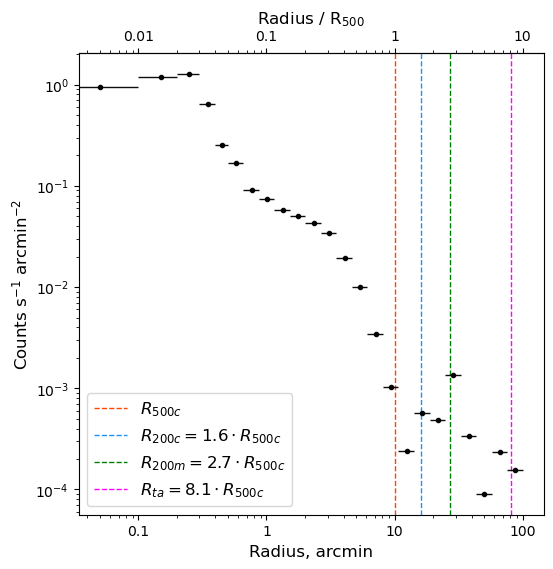

In [82]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=cl_num,
                          hist=np.rot90(tyty1),
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

Filtered:

In [ ]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=np.rot90(np.flip(tyty2)),
                          mmmask=np.rot90(np.flip(msk)),
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

# Calculating unmasked profiles for all clusters:

In [ ]:
%run -i 'utils/scripts_stacking.py'

df_all = pd.DataFrame()
df_dop = pd.DataFrame()

for cl_num in tqdm(clusters.index):

    pho_hist = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=False,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(clusternumber=cl_num,
                              hist=pho_hist,
                              mmmask='no',
                              field_length=20,
                              draw=False,
                              ARF_weights=True,
                              errors=False)
    
    df_add = pd.DataFrame(brbr[1]).T
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-0323.csv', sep=' ', header=False, index=True)

# Comparing luminosities from profiles and from spectral analysis

In [9]:
yarkosti = pd.read_csv("brpr-0520-noarf.csv", sep='\\s+', header=None, index_col=0)
yarkosti.index=np.array(clusters.index[:])
display(yarkosti)
#yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
171,0.000199,0.000185,0.000335,0.000405,0.000344,0.000205,0.000109,0.000059,0.000037,0.000021,...,0.000002,5.943149e-07,1.472801e-07,2.826509e-08,1.528718e-08,3.923837e-08,8.439850e-08,1.063447e-07,2.377401e-07,2.433984e-07
187,0.000017,0.000018,0.000037,0.000025,0.000030,0.000031,0.000026,0.000031,0.000105,0.000029,...,0.000003,1.100379e-06,2.869374e-07,1.204232e-07,3.828306e-07,1.731071e-06,5.686491e-07,3.342779e-07,3.460620e-08,6.370277e-07
350,0.000589,0.000716,0.000799,0.000410,0.000159,0.000106,0.000053,0.000047,0.000035,0.000029,...,0.000002,6.032001e-07,1.533227e-07,3.380764e-07,2.853230e-07,8.258296e-07,2.078047e-07,5.595154e-08,1.406223e-07,9.185476e-08
820,0.000065,0.000071,0.000065,0.000071,0.000062,0.000074,0.000136,0.000056,0.000029,0.000020,...,0.000002,5.952595e-07,1.175818e-07,4.907930e-08,5.432400e-08,8.850575e-09,1.910007e-08,6.492416e-08,2.845053e-08,8.801779e-08
1245,0.000074,0.000157,0.000264,0.000434,0.000360,0.000142,0.000042,0.000029,0.000018,0.000014,...,0.000001,5.627987e-07,2.018070e-07,2.509310e-08,2.729921e-08,7.868698e-08,2.911300e-08,1.352614e-07,3.214752e-08,3.592163e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0.000027,0.000026,0.000032,0.000031,0.000035,0.000033,0.000032,0.000038,0.000034,0.000025,...,0.000003,2.063796e-06,5.150167e-07,1.367628e-07,2.748220e-07,4.102093e-07,7.766149e-08,6.983053e-08,5.965304e-08,1.435550e-07
18610,0.000014,0.000014,0.000017,0.000015,0.000021,0.000016,0.000017,0.000021,0.000020,0.000026,...,0.000002,1.219137e-06,3.275332e-07,1.113519e-07,2.256595e-08,9.851573e-08,2.395525e-08,1.557899e-07,1.934431e-07,1.168286e-07
19523,0.000014,0.000010,0.000009,0.000020,0.000031,0.000109,0.000118,0.000020,0.000013,0.000009,...,0.000001,6.410783e-07,3.207307e-07,1.254775e-07,4.600986e-08,7.181500e-08,8.497601e-08,2.686827e-08,2.154592e-08,1.216391e-07
19771,0.000184,0.000272,0.000455,0.000639,0.000410,0.000167,0.000103,0.000079,0.000058,0.000041,...,0.000002,5.500858e-07,3.950159e-07,4.912943e-08,3.303150e-08,8.548235e-09,1.881430e-08,1.828910e-08,1.155269e-07,2.742256e-08


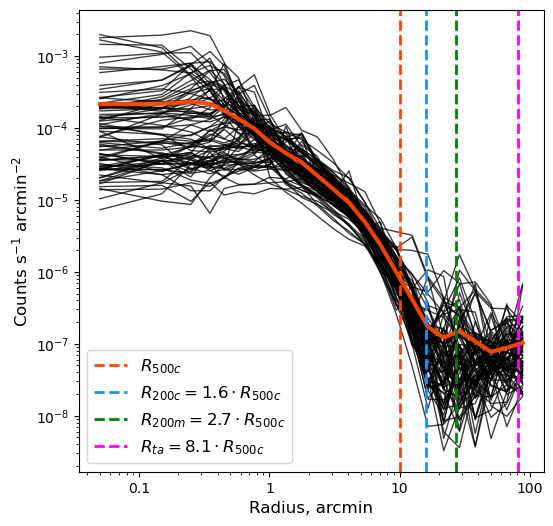

In [10]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti.to_numpy()[8])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti.to_numpy()[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=1
    else:
        llww=1
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \\cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \\cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \\cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)

plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

## Uploading a table

In [11]:
table_name = '0_clean_50_1.0_unfiltered'
read_table = pd.read_csv('../magneticum/tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))

lspec, lspec_err = [lll[1]*1e44 for lll in lumin_usr], [lll[2]*1e44 for lll in lumin_usr]

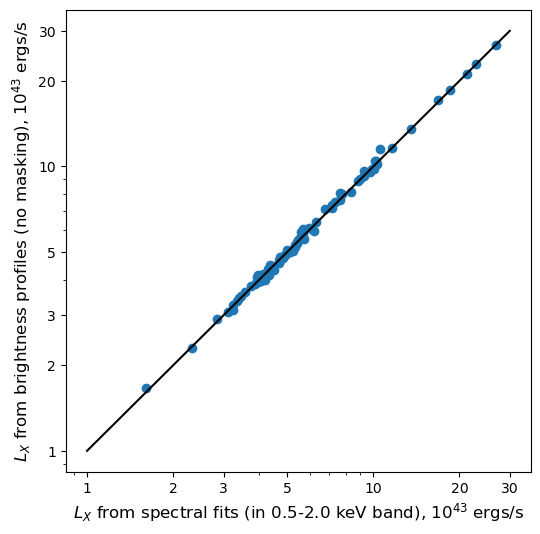

In [12]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]

plt.figure(figsize=(6,6))

lums = []

for c in clusters.index[:84]:

    snap_id_str = binned_clusters[c][1]   # id of photon list

    if snap_id_str == '124':
        zslice = 0.174192889973847
    elif snap_id_str == '128':
        zslice = 0.13708140389145
    elif snap_id_str == '132':
        zslice = 0.101142861718869
    elif snap_id_str == '136':
        zslice = 0.0663401914452304
    elif snap_id_str == '140':
        zslice = 0.032637492755919
    
    cc = clusters.loc[c]
    ztrue = cc["z_true"]
    R_500 = cc["R500"]/0.704/(1+zslice)  # kpc 
    
    D_A = FlatLambdaCDM(H0=100*0.704, Om0=0.272).angular_diameter_distance(ztrue)*1000 # kpc
    R_500_rescaled = R_500/D_A.value*180/np.pi*60 

    rr = np.array(setka)/r500r*R_500_rescaled
    dr = np.diff(setka_bins/r500r)*R_500_rescaled
        
    I_x = yarkosti.loc[c].to_numpy()
    
    D_L = FlatLambdaCDM(H0=100*0.704, Om0=0.272).luminosity_distance(ztrue).value # Mpc
    N = np.sum(2*np.pi*rr[:16]*dr[:16]*I_x[:16]) # cts/s
#    print(N, 'cts/s')
    flx = N / 1 * (1.0*1.60218e-9) # ergs / s / cm2
    #print(flx, 'ergs / s / cm2')
    lum = flx  * 4*np.pi * D_L**2 * (3.08e24)**2
    #print(lum, lspec[clusters.index.get_loc(c)])
    
    lums.append(lum)

plt.scatter(lspec, np.array(lums) )#, xerr=lspec_err, linewidth=0, elinewidth=1)

plt.plot([1e43, 3e44], [1e43, 3e44], color='k')
plt.ylabel("$L_X$ from brightness profiles (no masking), $10^{43}$ ergs/s", fontsize=12)
plt.xlabel("$L_X$ from spectral fits (in 0.5-2.0 keV band), $10^{43}$ ergs/s", fontsize=12)
plt.xscale("log")
plt.yscale("log")
llll = [1,2,3,5,10,20,30] #, 50, 100, 200, 300]
plt.xticks(np.array(llll)*1e43, llll)
plt.yticks(np.array(llll)*1e43, llll)
plt.show()

# Uploading and rescaling of unmasked and not normalized profiles in 0.3-2.3 keV

In [50]:
yarkosti = pd.read_csv("brpr-0323.csv", sep='\\s+', header=None, index_col=0)
yarkosti.index=np.array(clusters.index[:])

#yarkosti = yarkosti.to_numpy()

#yarkosti_31 = yarkosti.loc[yarkosti.index.isin(clusters_31.index)]

display(yarkosti)

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
171,0.032730,0.032586,0.059244,0.071197,0.062148,0.036322,0.019271,0.010700,0.006678,0.004019,...,0.000332,0.000110,0.000026,0.000005,0.000003,0.000008,1.661548e-05,0.000020,0.000044,0.000045
187,0.004032,0.003975,0.005468,0.004553,0.005367,0.004975,0.004479,0.005720,0.018957,0.005232,...,0.000538,0.000213,0.000058,0.000022,0.000069,0.000327,1.072281e-04,0.000061,0.000007,0.000122
350,0.106738,0.133957,0.145612,0.072767,0.028723,0.018979,0.010401,0.008383,0.006554,0.005761,...,0.000392,0.000116,0.000027,0.000064,0.000056,0.000154,3.796139e-05,0.000010,0.000026,0.000018
820,0.012027,0.014814,0.013073,0.013821,0.011429,0.014212,0.025214,0.010685,0.005535,0.003951,...,0.000450,0.000116,0.000024,0.000011,0.000010,0.000002,3.730044e-06,0.000013,0.000006,0.000018
1245,0.014939,0.029406,0.048687,0.079864,0.064001,0.026592,0.007395,0.005187,0.003504,0.002630,...,0.000214,0.000112,0.000036,0.000004,0.000006,0.000017,5.738022e-06,0.000024,0.000007,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0.004875,0.005273,0.006064,0.005736,0.006489,0.006265,0.006092,0.006999,0.006325,0.004713,...,0.000654,0.000375,0.000095,0.000025,0.000049,0.000072,1.346062e-05,0.000011,0.000009,0.000024
18610,0.002771,0.002784,0.003376,0.003042,0.003598,0.003218,0.003258,0.003822,0.003742,0.004832,...,0.000436,0.000224,0.000062,0.000020,0.000004,0.000016,4.051832e-06,0.000025,0.000033,0.000020
19523,0.003036,0.002010,0.001786,0.003972,0.005190,0.017378,0.018660,0.003580,0.002397,0.001766,...,0.000233,0.000125,0.000062,0.000023,0.000008,0.000013,1.428625e-05,0.000004,0.000003,0.000020
19771,0.033491,0.048082,0.080953,0.112557,0.072406,0.030617,0.019415,0.015132,0.011036,0.007830,...,0.000309,0.000105,0.000072,0.000009,0.000006,0.000002,3.188306e-06,0.000003,0.000020,0.000005


## Factors:

In [51]:
R500S = []
reds = []

for c in clusters.index[:84]:

    snap_id_str = binned_clusters[c][1]   # id of photon list

    if snap_id_str == '124':
        zslice = 0.174192889973847
    elif snap_id_str == '128':
        zslice = 0.13708140389145
    elif snap_id_str == '132':
        zslice = 0.101142861718869
    elif snap_id_str == '136':
        zslice = 0.0663401914452304
    elif snap_id_str == '140':
        zslice = 0.032637492755919
    
    cc = clusters.loc[c]
    ztrue = cc["z_true"]
    R_500 = cc["R500"]/0.704/(1+zslice)  # kpc

    R500S.append(R_500)
    reds.append(ztrue)

## All profiles:

<Figure size 640x480 with 0 Axes>

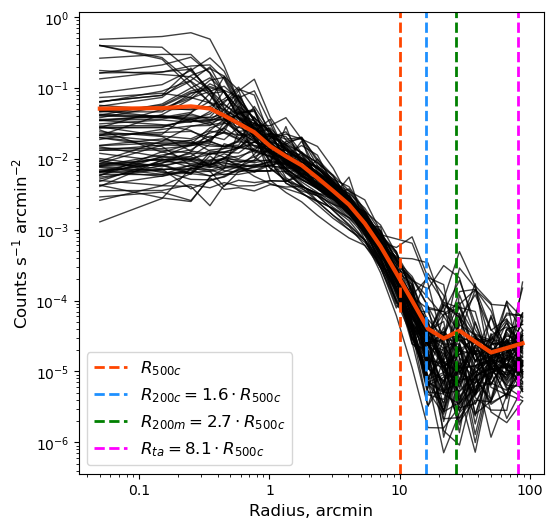

In [52]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti.to_numpy()[8])*0

for i in range(0, len(yarkosti[::])):

    one = yarkosti.to_numpy()[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=1
    else:
        llww=1

    f1 = 1000/R500S[i]
    f2 = E(reds[i])**(-4)*(1+reds[i])**3
    factor = f1*f2
    one = one*factor
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \\cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \\cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \\cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)

plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

## Stacked image:

In [ ]:
%run -i 'utils/scripts_stacking.py'

length = 2001

total_hist_unfiltered = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=False, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist_unfiltered = np.add(total_hist_unfiltered, pho_hist)

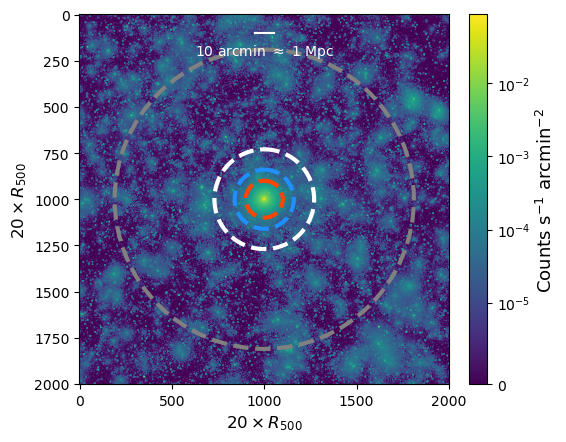

In [24]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist_unfiltered/84), norm=matplotlib.colors.SymLogNorm(linthresh=0.00001, linscale=1), 
           origin='upper')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label(f"Counts s$^{{-1}}$ arcmin$^{{-2}}$", size=13)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

## Figure:

In [ ]:
#yar31 = yar

  0%|          | 0/24 [00:00<?, ?it/s]

/home/aleksei/work/clusters/stacking/utils/scripts_stacking.py:456: RuntimeWarning: invalid value encountered in scalar divide
  brw2 = (hist*cw).sum()/sum(cw.flatten())


<Figure size 640x480 with 0 Axes>

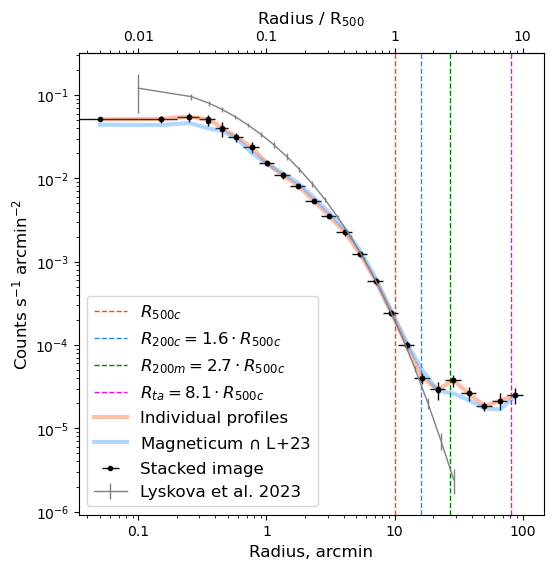

In [54]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=19787,           # choose any
                          hist=total_hist_unfiltered/84,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True,
                          errors=True)

#plt.ylim(1e-8, 2e1)

plt.plot(np.array(setka)/r500r*10, 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.35,
         color='orangered', label='Individual profiles')

plt.plot(np.array(setka)/r500r*10, 
         np.array(yar31)/31, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.35,
         color='dodgerblue', label='Magneticum $\\cap$ L+23')

plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, color='grey', label='Lyskova et al. 2023')

plt.legend(loc=3, fontsize=12)

#plt.savefig('profiles.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Filtering of images

In [ ]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001, 
                                     ARF_weights=False)

plt.show()

In [ ]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty1 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001,
                                     ARF_weights=True)
plt.show()

In [ ]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty2, msk = extract_photons_from_cluster(cl_num, 
                                          delete_superfluous=True, 
                                          draw=True,
                                          histlen=2001,
                                          ARF_weights=True)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(tyty2*(msk))), origin='lower', norm=matplotlib.colors.SymLogNorm(linthresh=0.0001, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

In [ ]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(msk)), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

In [ ]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(wedge(4, 2001))), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

# And now the same for filtered images:

In [ ]:
%run -i 'utils/scripts_stacking.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist, mmaasskk = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=True,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(clusternumber=cl_num,
                              hist=pho_hist,
                              mmmask=mmaasskk,
                              field_length=20,
                              draw=False,
                              ARF_weights=True,
                              errors=False)
    
    df_add = pd.DataFrame(brbr[1]).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-0323-masked.csv', sep=' ', header=False, index=True)

# Uploading masked profiles

In [62]:
yarkosti = pd.read_csv("brpr-0323-masked.csv", sep='\\s+', header=None, index_col=0)
yarkosti.index = np.array(clusters.index[:])
print(len(yarkosti))
#display(yarkosti)
yarkosti_84 = yarkosti.to_numpy()

yarkosti_31 = yarkosti.loc[yarkosti.index.isin(clusters_31.index)]
print(len(yarkosti_31))
#display(yarkosti_31) 
yarkosti_31 = yarkosti_31.to_numpy()

84
31


In [9]:
num1 = np.array(yar)/31
num1

array([4.57267544e-03, 4.78839177e-03, 5.69857407e-03, 5.04356821e-03,
       3.98392625e-03, 3.44325372e-03, 2.29287017e-03, 1.51689902e-03,
       1.24345476e-03, 9.31021393e-04, 5.87603794e-04, 3.92404944e-04,
       2.32255581e-04, 1.16193253e-04, 4.78158193e-05, 1.74292107e-05,
       5.44514603e-06, 3.24664142e-06, 2.58323287e-06, 2.12144553e-06,
       1.62558944e-06, 1.18737752e-06, 1.53338179e-06, 1.72175134e-06])

In [11]:
num2 = np.array(yar)/84
num1, num2

(array([4.57267544e-03, 4.78839177e-03, 5.69857407e-03, 5.04356821e-03,
        3.98392625e-03, 3.44325372e-03, 2.29287017e-03, 1.51689902e-03,
        1.24345476e-03, 9.31021393e-04, 5.87603794e-04, 3.92404944e-04,
        2.32255581e-04, 1.16193253e-04, 4.78158193e-05, 1.74292107e-05,
        5.44514603e-06, 3.24664142e-06, 2.58323287e-06, 2.12144553e-06,
        1.62558944e-06, 1.18737752e-06, 1.53338179e-06, 1.72175134e-06]),
 array([1.57680307e-02, 1.60937961e-02, 1.58084938e-02, 1.26269280e-02,
        9.06575997e-03, 6.84341215e-03, 4.78060977e-03, 2.80298013e-03,
        2.06340156e-03, 1.54687248e-03, 9.71842267e-04, 6.26842277e-04,
        3.81827824e-04, 1.90121527e-04, 8.51039166e-05, 3.31221770e-05,
        1.04128228e-05, 6.59255488e-06, 5.85490164e-06, 4.83275899e-06,
        3.25742722e-06, 2.86345491e-06, 3.39691280e-06, 3.17890285e-06]))

In [63]:
R500S = []
reds = []

for c in clusters.index[:84]:

    snap_id_str = binned_clusters[c][1]   # id of photon list

    if snap_id_str == '124':
        zslice = 0.174192889973847
    elif snap_id_str == '128':
        zslice = 0.13708140389145
    elif snap_id_str == '132':
        zslice = 0.101142861718869
    elif snap_id_str == '136':
        zslice = 0.0663401914452304
    elif snap_id_str == '140':
        zslice = 0.032637492755919
    
    cc = clusters.loc[c]
    ztrue = cc["z_true"]
    R_500 = cc["R500"]/0.704/(1+zslice)  # kpc

    R500S.append(R_500)
    reds.append(ztrue)

<Figure size 640x480 with 0 Axes>

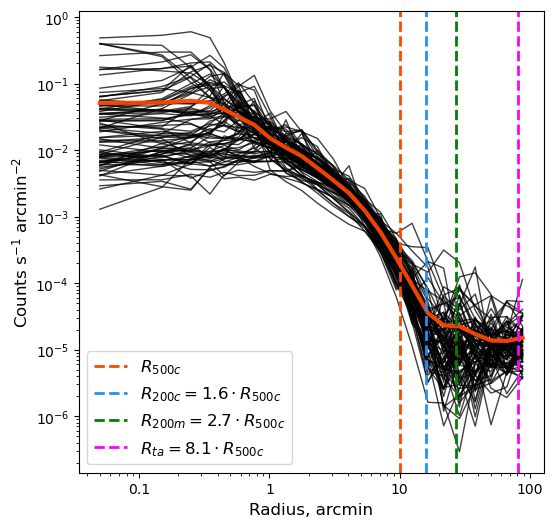

In [66]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti_84[0])*0

for i in range(0, len(yarkosti_84[::])):

    one = yarkosti_84[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1

    f1 = 1000/R500S[i]
    f2 = E(reds[i])**(-4)*(1+reds[i])**3
    factor = f1*f2
    one = one*factor
    
    yar = yar + one
    
    if one[-1]==np.nan:
        llww=10
        
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \\cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \\cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \\cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [69]:
%run -i 'utils/scripts_stacking.py'

length = 2001

total_hist_masked = np.zeros((length, length))
total_mask = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist, mskk = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=True, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist_masked = np.add(total_hist_masked, pho_hist*mskk)
    total_mask = np.add(total_mask, mskk)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

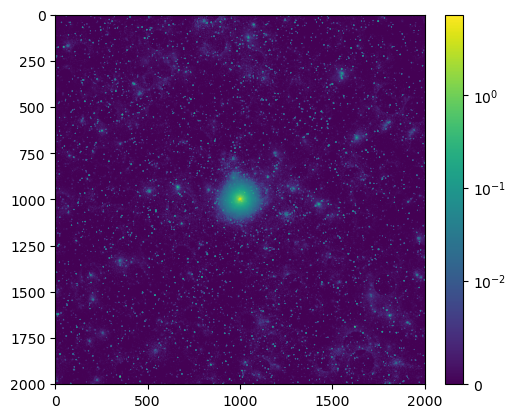

In [70]:
plt.imshow(np.rot90(total_hist_masked), norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

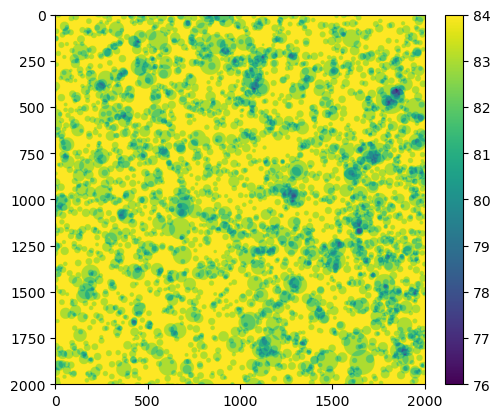

In [71]:
#total_mask[total_mask > 1] = True

plt.imshow(np.rot90(total_mask))
plt.colorbar(fraction=0.046, pad=0.04)

In [72]:
reduced_hist = np.divide(total_hist_masked, total_mask)

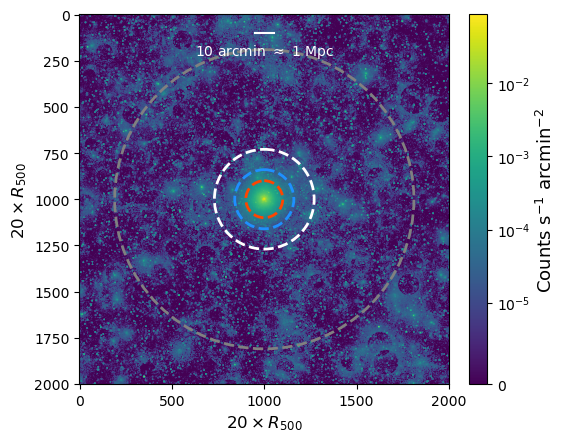

In [73]:
half_length = int(length/2)
r500r = int(half_length/10)

#mask_rescaled = 

plt.imshow(np.rot90(reduced_hist), norm=matplotlib.colors.SymLogNorm(linthresh=0.00001, linscale=1), 
           origin='upper')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label(f"Counts s$^{{-1}}$ arcmin$^{{-2}}$", size=13)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=2, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

/home/aleksei/work/clusters/stacking/utils/scripts_stacking.py:456: RuntimeWarning: invalid value encountered in scalar divide
  brw2 = (hist*cw).sum()/sum(cw.flatten())


<Figure size 640x480 with 0 Axes>

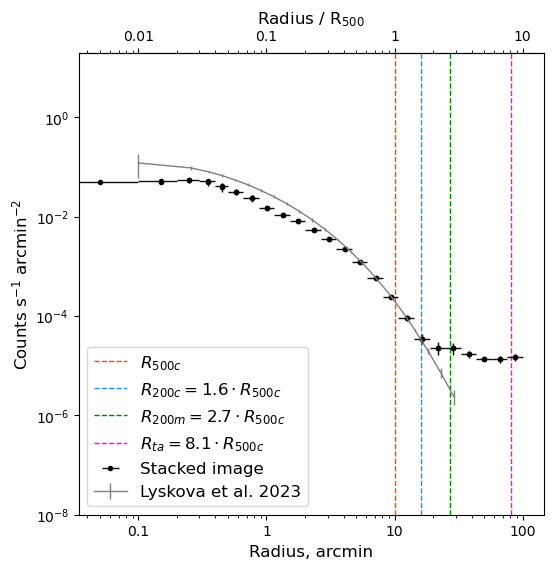

In [75]:
%run -i 'utils/scripts_stacking.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(clusternumber=19787,   # choose any
                          hist=reduced_hist,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True,
                          errors=True)

plt.ylim(1e-8, 20)

plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, color='grey', label='Lyskova et al. 2023')
plt.legend(loc=3, fontsize=12)

plt.show()

#### Fitting: simple beta-model

In [30]:
def beta_model_surface_brightness(r, S0, rc, beta):
    
    return S0 * (1 + (r / rc)**2)**(-3 * beta / 2)

In [31]:
true_S0 = 1.0
true_rc = 0.5
true_beta = 2/3

In [32]:
# Fit the beta model to the noisy data
initial_guess = [1.0, 0.5, 0.67]  # Initial guess for S0, rc, beta
popt, pcov = curve_fit(beta_model_surface_brightness, rr, np.array(brbr), p0=initial_guess)

In [33]:
# Extract fitted parameters
fitted_S0, fitted_rc, fitted_beta = popt
print(f"Fitted parameters: S0 = {fitted_S0}, rc = {fitted_rc}, beta = {fitted_beta}")

Fitted parameters: S0 = 0.017172107152232323, rc = 0.6156207500305437, beta = 0.870312904264062


In [34]:
# Generate fitted values for plotting
S_fitted = beta_model_surface_brightness(rr, *popt)
#plt.plot(rr, S_fitted, label='Fitted Beta Model', color='red', ls='--', lw=2)

### Upper and lower borders:

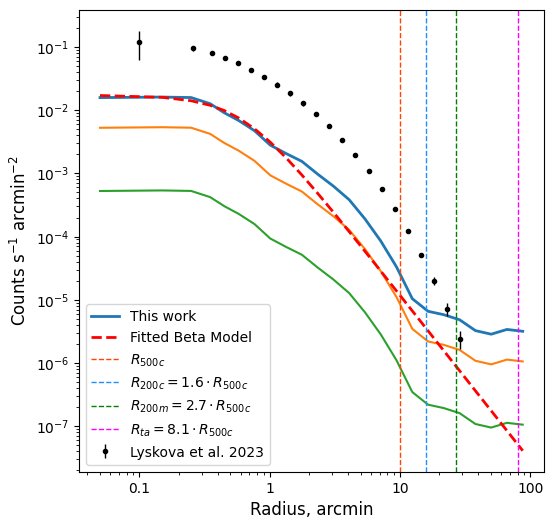

In [35]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)

plt.figure(figsize=(6, 6))

plt.plot(rr, np.array(brbr), label='This work', lw=2)
plt.plot(rr, np.array(brbr)/3.) # np.geomspace(2.3, 0.1*r_pixels_max, 24))
plt.plot(rr, np.array(brbr)/30)
plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=0, elinewidth=1, markersize=3, marker='o', color='black', label='Lyskova et al. 2023')

plt.plot(rr, S_fitted, label='Fitted Beta Model', color='red', ls='--', lw=2)

plt.xlabel("Radius, arcmin", fontsize=12)
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=1)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=1)

plt.legend(loc=3, fontsize=10)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])

plt.show()

# Natalya's data:

## Profile from Fig.3

In [18]:
Ix = pd.read_csv("natalya/sb_fig3_errorbars.dat", sep='\\s+', header=None)
display(Ix)
#yarkosti = yarkosti.to_numpy()

,0,1,2,3
0,0.100019,0.120754,0.061235,0.180273
1,0.258809,0.095725,0.087513,0.103937
2,0.358865,0.079372,0.074380,0.084363
3,0.452170,0.067034,0.062723,0.071345
4,0.569734,0.054965,0.051957,0.057972
5,0.717865,0.043767,0.040844,0.046690
6,0.904510,0.033826,0.031296,0.036357
7,1.139680,0.025341,0.023278,0.027405
8,1.436000,0.018363,0.016830,0.019895
9,1.809360,0.012834,0.011799,0.013868


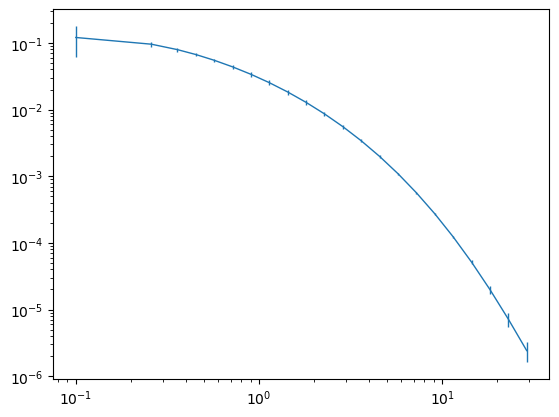

In [19]:
plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1)
plt.xscale("log")
plt.yscale("log")

In [19]:
SMPL = pd.read_csv("sample.dat", sep='\s+', header=0)
display(SMPL)

,Name,M500c(10^14*M_sun),R500c(kpc),z
0,G028.89+60.13,4.47,1133.8,0.1530
1,G031.93+78.71,2.72,973.8,0.0724
2,G033.81+77.18,4.46,1150.2,0.0622
3,G040.03+74.95,2.34,927.8,0.0612
4,G040.58+77.12,2.57,955.2,0.0748
5,G041.45+29.10,5.41,1203.1,0.1780
6,G042.81+56.61,4.22,1127.4,0.0723
7,G044.20+48.66,8.77,1434.7,0.0894
8,G046.88+56.48,5.10,1192.5,0.1145
9,G048.10+57.16,3.54,1062.3,0.0777


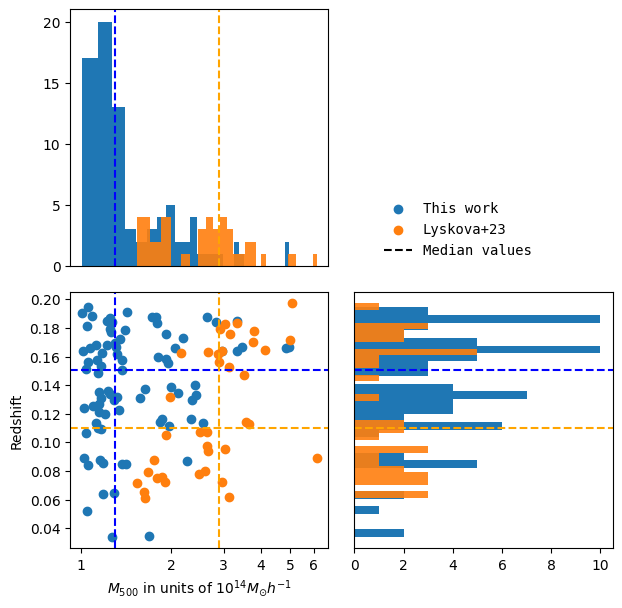

In [20]:
plt.figure(figsize = (7,7))

plt.subplot(221)

plt.hist(clusters["M500"]/10**14, bins=30, histtype='stepfilled')
plt.hist(SMPL["M500c(10^14*M_sun)"]*0.7, bins=30, histtype='stepfilled', alpha=0.9)
#plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
#plt.xticks([])
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='blue')
plt.axvline(np.median(SMPL["M500c(10^14*M_sun)"]*0.704), linestyle='--', color='orange')
plt.xscale("log")
#plt.xticks([1,2,3,4,5], [1,2,3,4,5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks([0,5,10,15,20], [0,5,10,15,20])

plt.subplot(224)

plt.hist(clusters["z_true"], bins=30, histtype='stepfilled', orientation="horizontal")
plt.hist(SMPL["z"], bins=30, histtype='stepfilled', orientation="horizontal", alpha=0.9)
#plt.xlabel("Redshift $z_{true}$")
plt.yticks([])
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='blue')
plt.axhline(np.median(SMPL["z"]), linestyle='--', color='orange')

plt.subplot(223)

plt.scatter(clusters["M500"]/10**14, clusters["z_true"], label='This work')
plt.scatter(SMPL["M500c(10^14*M_sun)"]*0.7, SMPL["z"], label='Lyskova+23')
plt.ylabel("Redshift")
plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.xscale("log")
plt.xticks([1,2,3,4,5,6], [1,2,3,4,5,6])
#plt.yscale("log")
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='blue')
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='blue')
plt.axvline(np.median(SMPL["M500c(10^14*M_sun)"]*0.704), linestyle='--', color='orange')
plt.axhline(np.median(SMPL["z"]), linestyle='--', color='orange')
plt.plot([], [], linestyle='--', color='black', label="Median values")

plt.legend(fontsize=15, prop={'family': 'monospace'},
           frameon=False,
           loc='upper center', bbox_to_anchor=(1.5, 1.4),
           fancybox=True, shadow=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('figures/histogram_84.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [70]:
min(SMPL["M500c(10^14*M_sun)"]*0.704)

1.5488

In [26]:
MASS4 = pd.read_csv("natalya/1234.dat", sep='\s+', header=0, index_col=0)
display(MASS4)

,Mass,Redshift,"R500,arcmin","R,kpc",filename
#,,,,,
1,5.900000e+14,0.1644,7.33,1241.3,fc10.1_Mass5.9e14_z016.radial
2,3.540000e+14,0.0777,12.04,1062.3,fc10.2_Mass3.5e14_z008.radial
3,4.340000e+14,0.0953,10.69,1133.7,fc10.3_Mass4.3e14_z01.radial
4,8.770000e+14,0.0894,14.33,1434.7,fc10.4_Mass8.8e14_z009.radial


(array([1., 0., 3., 2., 2., 5., 2., 1., 0., 0., 1., 0., 2., 3., 0., 3., 2.,
        3., 5., 3.]),
 array([0.8388288 , 0.84473525, 0.8506417 , 0.85654815, 0.8624546 ,
        0.86836106, 0.87426751, 0.88017396, 0.88608041, 0.89198686,
        0.89789331, 0.90379977, 0.90970622, 0.91561267, 0.92151912,
        0.92742557, 0.93333202, 0.93923848, 0.94514493, 0.95105138,
        0.95695783]),
 <BarContainer object of 20 artists>)

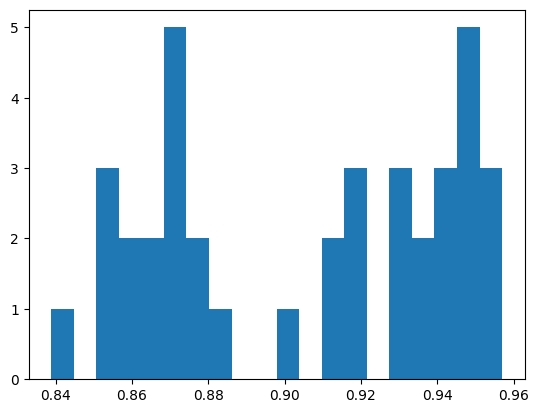

In [27]:
plt.hist(E(SMPL["z"])**(-4)*(1+SMPL["z"]), bins=20)

In [73]:
#bros = [2603, 1707, 11141, 2471]
bros = [2471, 11141, 1707, 2603]
pp = clusters.loc[clusters.index.isin(bros)]
mmm = pp.index
display(pp)
mmm

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0


Index([1707, 2471, 2603, 11141], dtype='int64')

In [74]:
mmm = yarkosti.loc[yarkosti.index.isin(bros)].to_numpy()
mmm

array([[9.72467032e-04, 8.34218428e-04, 9.99250669e-04, 9.86218582e-04,
        9.87169141e-04, 1.00421674e-03, 1.06513022e-03, 9.86852937e-04,
        1.01197049e-03, 9.33479011e-04, 5.61966739e-04, 3.79472802e-04,
        2.41656839e-04, 1.10444874e-04, 4.14136170e-05, 1.06379496e-05,
        1.73813013e-06, 2.63965821e-07, 1.29364053e-07, 3.16930511e-07,
        1.59658964e-06, 8.89811925e-07, 1.37952263e-06, 1.59508304e-06],
       [2.09518408e-03, 2.39842863e-03, 2.53534522e-03, 2.17439699e-03,
        2.04061379e-03, 1.99108179e-03, 2.17130345e-03, 2.24446341e-03,
        1.15449445e-03, 8.39862799e-04, 6.53256233e-04, 2.70344074e-04,
        9.25537679e-05, 3.43663119e-05, 2.33917033e-05, 7.96392388e-06,
        7.26189178e-07, 1.57873919e-07, 5.62322945e-07, 3.75647799e-07,
        5.15728984e-07, 7.24699009e-07, 1.02026448e-06, 3.90701620e-07],
       [3.67020646e-03, 4.07574668e-03, 5.84800416e-03, 5.58587735e-03,
        3.09028851e-03, 2.10694345e-03, 1.34697537e-03, 1.1469

In [81]:
E(0)

1.0

In [21]:
fac1 = 1000/(clusters["R500"]/0.704)
fac2 =  E(clusters["z_true"])**(-4)*(1+clusters["z_true"])**3 
factor = fac1*fac2
fac1[171] #factor

1.023065476190476

749.2054189387177
0.20544064567260073
749.536834058672
0.11294151556544461
753.028839400163
0.07409428632076366
763.3112468408657
0.14468053167195785
772.6707592262335
0.25938271137805086
776.0277737367277
0.22295615107373876
782.9535438154609
0.0888892592466595
784.9586040532548
0.08389588038891141
785.3024144075879
0.3634601742125724
793.5772617933114
0.05100462335889924
795.8628839496164
0.30691208264710423
796.4360971305609
0.11731608175697197
797.5807643398026
0.061380092012220805
800.282047840167
0.16229605896592403
800.4198297419119
0.05358673962384877
805.1172611308913
0.2581800814344427
807.0526404372273
0.28532365615869276
813.1712548650506
0.2101902664326083
829.1719304674058
0.3393578625190665
831.4969294077865
0.15341822191560417
846.5840274611826
0.19048545307566656
854.5238357625049
0.3629590132124734
862.9951548847667
0.2906413374547323
866.0639715318172
0.35937268346621887
878.518142517372
0.48624192571422253
889.8319303665718
0.15225462995994746
890.6708925280633
0.13

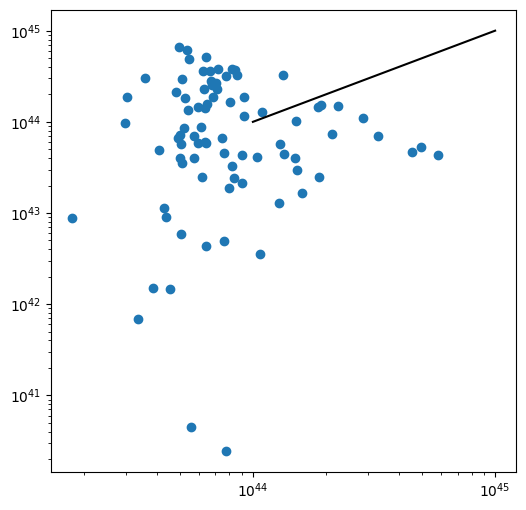

In [24]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)
dr = np.diff(setka_bins/r500r*(10*998/1000))

plt.figure(figsize=(6,6))

lums = []
lums_from_cat = clusters["Lx500"] / E(clusters["z_true"])

for c in clusters.index[:84]:
    #print(c)
        
    I_x = yarkosti.loc[c].to_numpy()
    #print(I_x)
    I_x = I_x/factor[c]
    
    D_L = FlatLambdaCDM(H0=100*0.704, Om0=0.272).luminosity_distance(clusters.loc[c]["z_true"]).value # Mpc
    print(D_L)
    #D_L = 343
    N = np.sum(2*np.pi*rr*dr*I_x) # cts/s
    print(N)
    flx = N / 140 * (1*1.60218e-9) # ergs / s / cm2
    #print(flx)
    lum = flx  * 4*np.pi * D_L**2 * (3.08e24)**2
    
    lums.append(lum)   # [a[1] for a in lumin_usr]

plt.scatter(np.array([a[1] for a in lumin_usr])*1e44, lums)
plt.plot([1e44, 1e45], [1e44, 1e45], color='k')
    
plt.xscale("log")
plt.yscale("log")

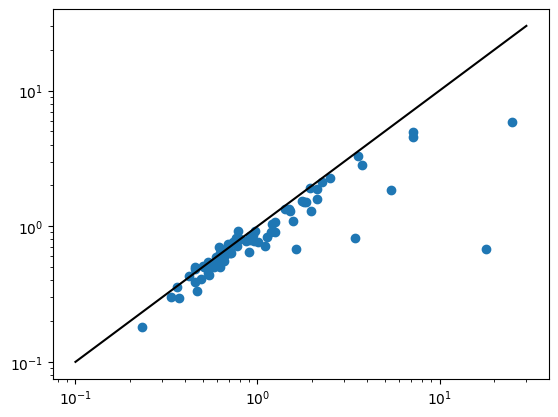

In [23]:
table_name =  '0_clean_50'
read_table = pd.read_csv('../magneticum/tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
#lumin_usr
lum_from_cat = clusters["Lx500"] #/ E(clusters["z_true"])

plt.plot([0.1, 30], [0.1, 30], color='k')
plt.scatter(lum_from_cat, [a[1] for a in lumin_usr])
plt.xscale("log")
plt.yscale("log")
plt.show()

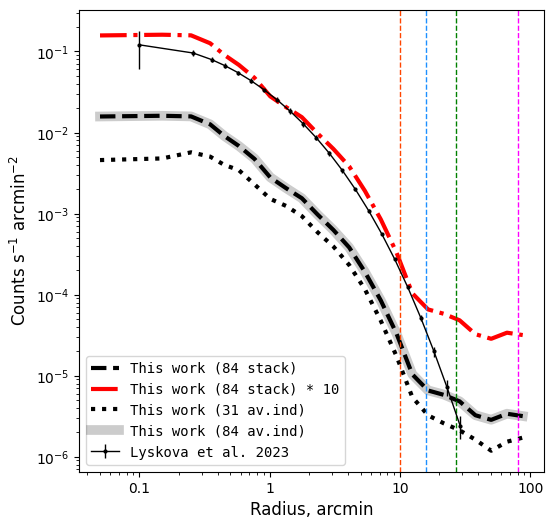

In [44]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)

plt.figure(figsize=(6, 6))

clrs = ['r','g','b','m']

r_sc = [7.33, 12.04, 10.69, 14.33]

#for i in range(1, 5):
#    clname = MASS4["filename"][i]
#    clust = pd.read_csv("natalya/"+clname, sep='\s+', header=None, index_col=None)
#    #display(cl1)
#    plt.errorbar(clust[0]/r_sc[i-1]*10, clust[2]-4e-4, xerr=clust[1]/r_sc[i-1], yerr=clust[3], lw=1, label='m'+MASS4["filename"][i][11:22]+" (L+23)", alpha=0.7, color=clrs[i-1])
    
plt.errorbar(Ix[0], Ix[1], yerr=(Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, elinewidth=1, markersize=2, marker='o', color='black', label='Lyskova et al. 2023')

plt.plot(rr, np.array(brbr), linestyle='--', label='This work (84 stack)', color='black', lw=3)

plt.plot(rr, np.array(brbr)*10, linestyle='-.', label='This work (84 stack) * 10', color='red', lw=3)

plt.plot(rr, np.array(num1), linestyle=':', label='This work (31 av.ind)', color='black', lw=3)

plt.plot(rr, np.array(num2), linestyle='-', label='This work (84 av.ind)', color='black', lw=7, alpha=0.2)

#for i in range(0, 4):
#    plt.plot(rr, np.array(mmm[i]), linestyle=':', color=clrs[i], label='m'+str(clusters.loc[bros[i]]["M500"]/1e14/0.7)+' (TW)', lw=2)

plt.xlabel("Radius, arcmin", fontsize=12)
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

plt.legend(loc=3, fontsize=10, prop={'family': 'monospace'})

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=1)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=1)


plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])

plt.savefig('profiles84-31.pdf')

plt.show()

In [ ]:
clusters.loc[pp[i]]["M500"]/1e14

In [101]:
bros

[2603, 1707, 11141, 2471]

In [37]:
bros = [2603, 1707, 11141, 2471]
pp = clusters.loc[clusters.index.isin(bros)]
mmm = pp.index
display(pp)
mmm

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0


Index([1707, 2471, 2603, 11141], dtype='int64')

In [38]:
display(pp)
pp.loc[bros[2]]

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
1707,18,0.544232,0.824044,0.185453,0.006258,5.732550e+14,0.163662,0.164504,2.948650e+14,889.117,8.645110e+12,3.045150e+13,4.06510,2.25340,0.000007,4.616500e+14,1401.22,0
2471,26,0.410317,0.585797,0.259098,0.006205,5.586460e+14,0.166428,0.166586,3.442820e+14,936.251,8.479620e+12,3.796000e+13,4.92884,7.17210,0.000009,4.998520e+14,1438.85,0
2603,6,0.771174,0.285485,0.273360,0.006894,7.662560e+14,0.166964,0.166016,4.940050e+14,1055.970,1.485500e+13,5.115290e+13,6.31768,7.12626,0.000013,6.558870e+14,1575.19,0
11141,17,0.429338,0.772537,0.353059,0.007187,4.513650e+14,0.132993,0.132934,2.425320e+14,816.259,6.788720e+12,2.558810e+13,3.96912,1.76391,0.000006,3.857750e+14,1293.18,0


ihal        1.700000e+01
x_pix       4.293381e-01
y_pix       7.725367e-01
z_pix       3.530592e-01
Rrel        7.186739e-03
Mvir        4.513650e+14
z_true      1.329933e-01
z_obs       1.329344e-01
M500        2.425320e+14
R500        8.162590e+02
Mstar500    6.788720e+12
Mgas500     2.558810e+13
T500        3.969120e+00
Lx500       1.763910e+00
Ysz500      6.314628e-06
M200        3.857750e+14
R200        1.293180e+03
flag        0.000000e+00
Name: 11141, dtype: float64

# Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

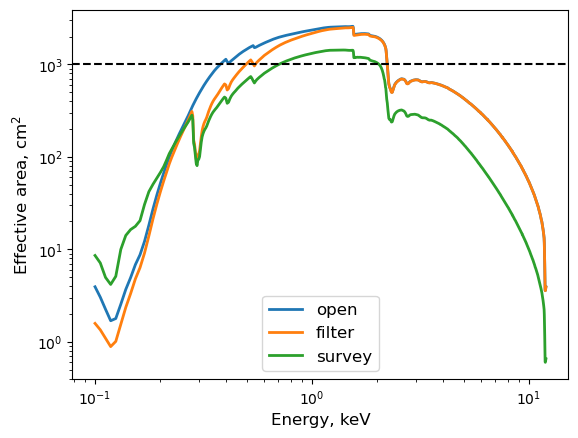

In [85]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

In [109]:
#T = Table(arf_filter)[np.where( (arf_filter["ENERG_LO"]>0.3) & (arf_filter["ENERG_HI"]<2.3))]
#T = Table(arf_open)[np.where( (arf_open["ENERG_LO"]>0.3) & (arf_open["ENERG_HI"]<2.3))]
T = Table(arf_survey)[np.where( (arf_survey["ENERG_LO"]>0.3) & (arf_survey["ENERG_HI"]<2.3))]
np.mean(T["SPECRESP"]), np.average(T["SPECRESP"], weights=T["ENERG_LO"]), np.mean(T["SPECRESP"]*T["ENERG_LO"]/np.sum(T["ENERG_LO"]))

(137.29648, 145.91815, 0.6344266)

In [111]:
print(2.333e+02 * (1.1506e-09/1.60218e-9))
print(1.982e+02 * (9.6533e-10/1.60218e-9))

167.54358436630093
119.41754734174687


The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [191]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [193]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014
